# Modern Hopfield Networks on the CIFAR10 dataset
**2025 Spring CSCI1470 Deep Learning Final Project**

**Authors: [Haosheng Wang](https://github.com/Wonder947), Edrick Guerrero, [Alfonso Gordon Cabello de los Cobos](https://github.com/AlfonsoR-GordonCC)**

In this project we have created a Hopfiel Network that memorizes patterns on a grayscale version of the CIFAR10 dataset for it to be able to reconstruct the images from altered samples using TensorFlow.

The goals for this project are:
1. BASE GOAL: high accuracy with small part of the dataset
2. TARGET GOAL: analyze how accuracy is affected by the quality (i.e. correlation between
images) and quantity (number of images to store) of the stored images/features.
3. STRETCH GOAL: analyze how accuracy is affected by the quality (e.g. amount of noise,
completeness of features) of the images/features used for retrieval.

# Division of Labor
- Haosheng Wang: Base_1, 
- Edrick Guerrero:
- Alfonso Gordon Cabello de los Cobos:

For BASE GOAL:
1. test existing pytorch implementation, including
    - testing the performance of existing implementation of modern hopfield network by the paper author as proof of concept
    - this shall walk through the whole process(1. load several images to be stored 2. add simple mask/noise to those images 3. init modern hopfield network 4. store the images 5. get retreived images using masked images 6. visualize the original image, the masked image, and the retrieved image), and produce a demo for later steps to follow
2. load dataset and image processing, including
    - writing methods for loading dataset and taking part of the image dataset for memorizing
    - writing methods for converting Images to gray-scale
    - writing methods for converting between Image (for visualization e.g. PIL Image) and Numpy Array (or Tensorflow tensor) back and forth
    - writing methods for corrupting the image (e.g. adding mask; adding noise)
3. modern hopfield netork core implementation, including
    - implement the class of modern hopfield network, using the same or similar architecture proposed by the paper
    - including at least init, store, retrieve
4. evaluation, including
    - define how to measure the "accuracy" between original Image and retrieved Image
    - use the above mentioned methods to write evaluation functions for the whole process, given input images to be stored, choice of masking quality(or images for retrieval), output hopfield network performance
    - run the function to compare the performance of the pytorch one and our tensorflow one

For TARGET GOAL:
1. analyze how accuracy is affected by the quality and quantity of images to be stored, including:
    - define how to measure the quality of images to be memorized/stored, e.g. define how to measure correlation between images
    - write function for the measurement, given input a batch of images to be measured, output the quality
    - visualize the relationship between the quality of the stored images and model accuracy (under same image quantity)
    - visualize the relationship between the quantity of the stored images and model accuracy (under the same image quality)

For STRETCH GOAL:
1. analyze how accuracy is affected by the quality of the masked images for retrieval, including:
    - define how to measure the quality of masked images, e.g. percentage of pixels masked; norm of noises added
    - write function for the measurement, given input a pair of original and masked image, output quality of the masked image e.g. quality a number from 0-1 where quality 1 means the masked image is same as original image, 0 means "completely different"
    - visualize the relationship between the quality of the masked/cropped images for retrieval and final accuracy (under same store Image quality and quantity)


First we import the needed libraries for the project to work.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib as mat
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'utils'

Then we import the CIFAR10 dataset and isolate samples according to the goals of the project. Those samples must be in grayscale ffor the Network to memorize patterns correctly.

Taking a 1% of the CIFAR10 dataset. Total of 600 images used.

Images selected.
 Checking if they are in grayscale...
Cool, we can continue. Here you have one of the images


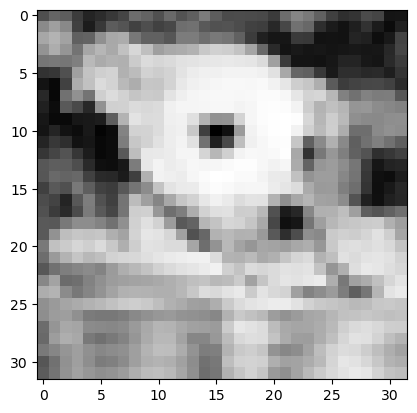

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

complete_imgs = np.concatenate((x_train, x_test), axis=0) #Create a Numpy Array with all the images

percentage = input("What percentage of the CIFAR10 dataset (60000 images) do you want to use?")
if percentage == '': #If the user has not decided a percentage, 10% is default
    percentage = 10
else:
    percentage = int(round(float(percentage)))

number_images_used = int(round(60000 * (percentage/100))) # Number of images that will be used

print(f'Taking a {percentage}% of the CIFAR10 dataset. Total of {number_images_used} images used.\n')

images_used = np.zeros(shape=(number_images_used, complete_imgs.shape[1], complete_imgs.shape[2], 1)) #Initialize a zero array with the same size of the complete

used_indices = set()
for i in range(number_images_used): #Lets use random images of the dataset
    n = np.random.randint(0, complete_imgs.shape[0])
    if n not in used_indices:
        images_used[i] = tf.image.rgb_to_grayscale(complete_imgs[n]) #Changes the images to grayscale
        used_indices.add(n)


print("Images selected.\n Checking if they are in grayscale...")
plt.imshow(images_used[0], cmap='gray')
print("Cool, we can continue. Here you have one of the images")

After getting the images and turned them into grayscale, is time to create the testing set by adding noise to the oringinal images.

Original image shape: (32, 32, 3), dtype: uint8
Noise shape: (32, 32, 3), dtype: <dtype: 'float32'>
Noisy image shape: (32, 32, 3), dtype: <dtype: 'float32'>


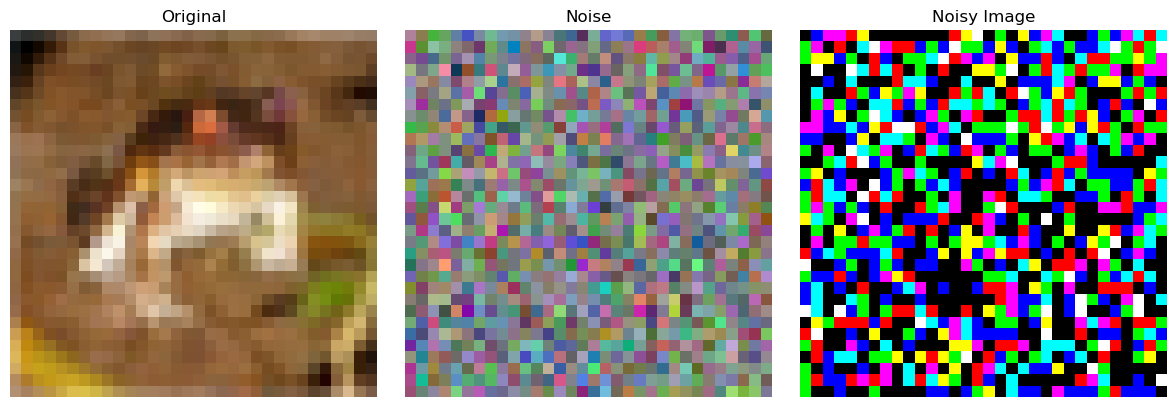

Checking if noise is added correctly...
Cool, we can continue. Here you have one of the images


In [126]:
noisy_imgs = np.zeros(shape=(number_images_used, complete_imgs.shape[1], complete_imgs.shape[2], 3))
actual_index = 0
""" for i in used_indices: 
    # Generate random noise with shape matching RGB image
    noise = tf.random.normal(
        shape=(complete_imgs.shape[1], complete_imgs.shape[2], 3)
    )
    
    # Add noise
    noisy_imgs[actual_index] = tf.add_n(complete_imgs[i], noise)
    actual_index += 1

    plt.imshow(noise)
    plt.imshow(complete_imgs[i]) """

original_img = complete_imgs[0]

# Print shapes and types to debug
print(f"Original image shape: {original_img.shape}, dtype: {original_img.dtype}")

# Convert the image to float32 explicitly
original_img_float = tf.cast(original_img, tf.float32)

# Generate stronger noise
stddev = 0.0001  # Higher value for more visible noise
noise = 0.1 * tf.random.normal(shape=original_img.shape, mean=0.0, stddev=stddev, dtype=tf.float32)
print(f"Noise shape: {noise.shape}, dtype: {noise.dtype}")

# Add noise - using simple addition instead of tf.add to avoid type issues
noisy_img = original_img_float + noise

# Apply modulo to keep in range [0,1]
noisy_img = tf.math.floormod(noisy_img, 1.0)
print(f"Noisy image shape: {noisy_img.shape}, dtype: {noisy_img.dtype}")

# Visualize with an explicit check to make sure images are compatible with imshow
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.array(original_img))  # Convert to numpy if needed
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Noise")
# Normalize noise for visualization
visual_noise = (noise - tf.reduce_min(noise)) / (tf.reduce_max(noise) - tf.reduce_min(noise))
plt.imshow(np.array(visual_noise))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Noisy Image")
plt.imshow(np.array(noisy_img))
plt.axis('off')

plt.tight_layout()
plt.show()


print("Checking if noise is added correctly...")
#plt.imshow(noisy_imgs[0])
print("Cool, we can continue. Here you have one of the images")



Another option is to apply a mask to the images.

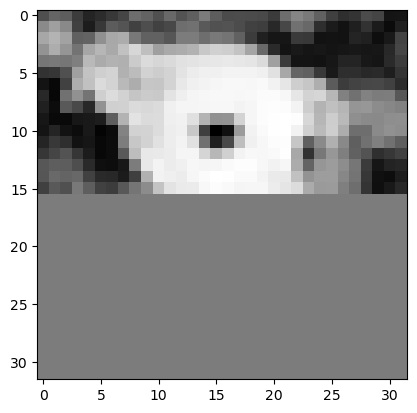

In [ ]:
images_masked_np = images_used
count = 0
for img in images_used:
    img[16:, :] = (255//2)
    images_masked_np[count] = img
    count += 1

print("Checking if making is done correctly...")
plt.imshow(images_masked_np[0], cmap='grey')
print("Cool, we can continue. Here you have one of the images")


Now we define simple functions for changing the images to NumPy arrays and viceversa, and for adding gaussian noise to an image.

In [ ]:
def img_to_arr(img, new_shape = (0,0)):
    arr = tf.keras.utils.img_to_array(img) # Converts the image to a NumPy array
    if new_shape == (0,0): # If no specific shape wanted, a 3D NumPy array is returned
        return arr
    else:
        new_arr = arr.reshape(new_shape) # Reshaping to desired shape
        return new_arr

def arr_to_img(arr):
    if arr.ndim == 3: # Checks if the array is 3D for the function to work properly
        return tf.keras.utils.array_to_img(img_arr)
    else:
        
        return 